# Finding Centroids
This notebook is a follow up of the notebook ilastik/pixels_classification_multiple_channels
We segment our images using the probability images obtained by ilastik and find the centroids of our objects.
TODO: describe the goal of the analysis

## Prepare the analysis
First of all, we need to import the libraries that we are going to use

In [1]:
import numpy as np
from Python import toolbox
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from getpass import getuser, getpass

And define a number of variables that we are going to use in the analysis

In [4]:
# RAW_DATASET_ID = 151  # the ID if the dataset containing th raw images
# PROBABILITIES_DATASET_ID = 301  # the ID of the dataset containing the probability images obtained by ilastik
RAW_DATASET_ID = 6205  # the ID if the dataset containing th raw images
PROBABILITIES_DATASET_ID = 6206  # the ID of the dataset containing the probability images obtained by ilastik
OMERO_SERVER = 'workshop.openmicroscopy.org' # the URL of our OMERO server
# OMERO_SERVER = 'localhost' # the URL of our OMERO server
PORT = 4064  # the port to connect to. Default is 4046
USER = input('Username: ')
PASSWORD = getpass()
# USER = 'facility_staff_1'
# PASSWORD = 'facility_staff_pw'
GROUP = None  # the group where the data is stored

## Explore your data
Now we can connect to OMERO, get some information on the dataset that we want to analyze and explore the data.

All the data is arranged in two datasets in the same project. One dataset contains the raw images and the other one 
contains the probability images extracted using Ilastik.

In [5]:
# Create a connection
conn = toolbox.open_connection(username=USER, password=PASSWORD, group=GROUP,
                               host=OMERO_SERVER, port=PORT)
print(f'Connection successful: {conn.isConnected()}')

# Get all the images contained in the raw dataset
raw_dataset = toolbox.get_dataset(connection=conn, dataset_id=RAW_DATASET_ID)
raw_images = toolbox.get_dataset_images(dataset=raw_dataset)
raw_images = list(raw_images)

# ... and in the probabilities dataset
prob_dataset = toolbox.get_dataset(connection=conn, dataset_id=PROBABILITIES_DATASET_ID)
prob_images = toolbox.get_dataset_images(dataset=prob_dataset)
prob_images = list(prob_images)

print('RAW IMAGES')
for image in raw_images[:3]:
    print(f'{image.getName()} Dimensions(z, c, t, x, y): {image.getSizeZ()}, {image.getSizeC()}, {image.getSizeT()}, {image.getSizeX()}, {image.getSizeY()}')

print('PROBABILITY IMAGES')
for image in prob_images[:12]:
    print(f'{image.getName()} Dimensions(z, c, t, x, y): {image.getSizeZ()}, {image.getSizeC()}, {image.getSizeT()}, {image.getSizeX()}, {image.getSizeY()}')
    

Connection successful: True
RAW IMAGES
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position001] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position002] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position003] Dimensions(z, c, t, x, y): 30, 4, 1, 1576, 1576
PROBABILITY IMAGES
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch1_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch2_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch3_Probabilities.npy Dimensions(z, c, t, x, y): 30, 2, 1, 1576, 1576
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_

You should see 
- a few of the raw images: 3-D stacks of 4 channels (DAPI, X1, X2 and X3) and
- one probability image per each channel in the raw images : 3-D stacks of 2 channels representing the probability of being Foreground (channel 0) and the probability of being Background (channel 1)

You may generate here a URL to access any of the images and have a look at them

In [5]:
print('For the raw images go to:')
print(f'http://{OMERO_SERVER}/webclient/img_detail/{raw_images[0].getId()}/')
print('For the probability images go to:')
print(f'http://{OMERO_SERVER}/webclient/img_detail/{prob_images[0].getId()}/')

For the raw images go to:
http://workshop.openmicroscopy.org/webclient/img_detail/55403/
For the probability images go to:
http://workshop.openmicroscopy.org/webclient/img_detail/55418/


### Exploring the raw values
You may load a part of an image as a numpy array ...

In [13]:
# you may use the 'range' optional parameters to get a specified plane or channel or a range (start_included, stop_not_included)
raw_data = toolbox.get_intensities(raw_images[0], 
                                   z_range=(14, 17),  # requests planes 16 and 17 if you start counting with 1
                                   c_range=0,  # This is the DAPI channel
                                   )

... and see the dimensions ...


In [9]:
# The dimensions are stored in the following order (z, c, t, x, y)
print(raw_data.shape)

(2, 1, 1, 1576, 1576)


... and raw values ...

In [10]:
print(raw_data[0,           # the first plane 15. Note again the 0 based indexing.
               0,           
               0,           # time point 0
               1100:1120,   # x pixels in the format from:until_but_excluded
               90:100]      # for example from pixel 90 until pixel 100 (the pixel at position 100 is excluded)
      )

[[1007  732  417  899  857  356  585  193  136  297]
 [ 854  746  328  330  162   29  301  353  204  278]
 [ 232  450  441  426  456   51  288  138  162  139]
 [ 249  431  133  199  315  256   64  211  100  145]
 [ 346  180  408  264  248   64  189   94  120  182]
 [ 197  182   53   94   34   38   18  162    5   21]
 [ 149  227  124  206  263    1    1    3    4    2]
 [ 262  212  135   27   62    4  127  203    3  120]
 [ 326  168  227   19   50   98   63    1    2    2]
 [   3   35    3   32   26  119  158   14  206    3]
 [  21  158   84   46    3   60    2    3  205    2]
 [   5   78    2   64   53   47    2    0    6    1]
 [   2    2  107  165    7    3    3   58   27    3]
 [   3    5   19    5    3    6    4   53    6    3]
 [   2    0  115  108   22    2  199    2  233    1]
 [   4   13    3   43   30    2    5    1    3   26]
 [  55    2  119   10    4    9    3    2    4    2]
 [  61    7    2    5   52    4   53    1   87    4]
 [   2   57   92    3    3    4    3    3    5

This raw_data object is a **_Numpy ndarray_** (n-dimensional array). 
This is Python's way to work very efficient with image data.

### Visualizing Numpy arrays
You may have a more convenient visualization of these data by using any of the python plotting libraries.
Python's standard library includes matplotlib. We imported previously *matplotlib.pyplot* as *plt* so let's use of it.

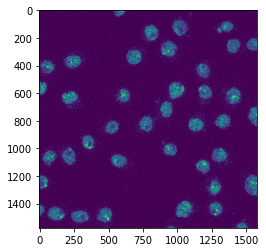

In [19]:
# We create a plot of the image, a Max Intensity Projection for example
MIP = raw_data.max(axis=0)  # specify the axis you want to use for the projection (c=0)
plt.imshow(MIP.squeeze())  # Observe the notation ':' for indexing. That means 'take everything'

# Creating the plot just creates it but you always have to show it
plt.show()

matplotlib may create very complex publication-ready plots. You may have a look at what you may do in [here](https://matplotlib.org/gallery.html).

## Running the analysis
Before moving further we have to arrange the images in the two lists so that every raw image has 4 probability images, one per channel.

In [20]:
# We are going to create a list of secondary lists where every secondary list 
# contains the probability images for one single raw image
rearranged_prob_images = list()
for raw_image in raw_images:  # We are looping through every raw image
    name = raw_image.getName()
    # We have to remove all the extra characters introduced by Leica. 
    # Not necessary in principle but as we did it for the probabilities we have to do it again
    name = name.replace('/', '_')
    name = name.replace('.lif [', '_')
    name = name.replace(']', '')
    
    rearranged_prob_images.append(list())  # We append an empty secondary list
    for subfix in ['DAPI_Probabilities',
                   'DAPI_Ch1_Probabilities',
                   'DAPI_Ch2_Probabilities',
                   'DAPI_Ch3_Probabilities']:
        for prob_image in prob_images:
            if name in prob_image.getname() and subfix in prob_image.getname():
                rearranged_prob_images[-1].append(prob_image)
                
# We don't need to keep two lists of probability images
# so we just replace the old list with the new one
prob_images = rearranged_prob_images

Always good to double check...

In [21]:
for i in range(5):
    print(raw_images[i].getName())
    for p in prob_images[i]: print(p.getName())

20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position001]
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch1_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch2_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position001_DAPI_Ch3_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647.lif [Mark_and_Find_001/Position002]
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Ch1_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position002_DAPI_Ch2_Probabilities.npy
20181012_S2Rplus_FISH_DAPI_X1-A488_X2-A555_X3-A647_Mark_and_Find_001_Position0

## Analyzing the images
Now we have everything ready to start our image analysis. We want to:
- Segment each channel using the probability values extracted by Ilastik in stead of the raw values.
- Save that segmentation into OMERO.
- While we still have the images in memory, we would like to calculate the centroids of the spots this time 
using the raw pixel values.
- We will save the centroid coordinates as a table associated to every image.

For most of the image analysis we are going to use scikit-image, a python iamge analysis library built on top of numpy.
We will have to fix, for each chanel:
 - an upper threshold marking what is going to be defined as an object
 - a lower threshold marking until what probability the object is going to segment
 TODO: put an image

### Creating an analysis function for every image
It's good practice to create a function where you encapsulate the logic of the analysis. Like that it is easier to focus on the work flow.

In [22]:
def run_analysis_image(raw_image, prob_image_list, up_thresholds, low_thresholds, size_thresholds, min_distance):
    """This function encapsulates our analysis of a single OMERO image"""
    
    # We get the raw intensity values from OMERO avoiding the DAPI channel
    raw_data = toolbox.get_intensities(raw_image, c_range=(1, 4))  # We get the raw data. Order is zctxy
    
    # We get the pixel size from OMERO
    pixel_size = toolbox.get_pixel_sizes(raw_image)
    
    # No measurement makes sense without units
    pixel_units = toolbox.get_pixel_units(raw_image)
    
    # We create to empty lists to store the measurements: 
    # Properties will contain a mix of different measures that might be useful later
    spots_props = list()
    # Positions will contain the centroid position of the different objects.
    spots_pos = list()
    
    # We now loop through every channel but the DAPI
    for ch_nr, ch_prob in enumerate(prob_image_list[1:]):  # Note the notation [1:]. It means from the second element to the end
        
        print(f'Analyzing channel {ch_nr}')        
        # We only want to segment on the probability of being foreground
        ch_prob_data = toolbox.get_intensities(ch_prob, c_range=0)
        
        labels = toolbox.segment_channel(channel=ch_prob_data.squeeze(),
                                         min_distance=1,
                                         sigma=None,
                                         method='hysteresis',
                                         hysteresis_levels=(low_thresholds[ch_nr], up_thresholds[ch_nr]))
                                         
        
        # The labels object contains now the segmentation masks for every found object
        # We use it to calculate the properties of every object using the raw data:
        # - The spots properties
        # - The spots positions
        spots_props_channel, spots_pos_channel = toolbox.compute_channel_spots_properties(channel=raw_data[:,ch_nr,:,:,:].squeeze(),
                                                                                          label_channel=labels)
        
        # We can filter out the spots that are too small
        for i in reversed(range(len(spots_props_channel))):
            if spots_props_channel[i]['area'] < size_thresholds[ch_nr]:
                del spots_props_channel[i]
                spots_pos_channel = np.delete(spots_pos_channel, obj=i, axis=0)
        
        # We append the spots properties and positions to the lists containing the image measurements
        spots_props.append(spots_props_channel)
        spots_pos.append(spots_pos_channel)
        
    # We have all the information collected in properties and positions
    # We can now apply a function to measure the pairwise distances between the spots
    pairwise_distances = toolbox.compute_distances_matrix(positions=spots_pos,
                                                          sigma=min_distance,  # this marks a threshold for the distances that are going to be accepted
                                                          pixel_size=pixel_size,
                                                          remove_MCN=True)
    return pairwise_distances
    

Now we have created a function we can apply it to every image in the dataset and collect the results

In [23]:
# Let's fix the probability hysteresis thresholds at which we want to segment.
# There will be an upper threshold and a lower threshold per channel.
upper_thresholds = (.99, .99, .99)
lower_thresholds = (.6, .6, .6)

# We are going to use a size filter to remove the objects that are too small
size_thresholds = (800, 800, 800)

# We should define a minimum distance threshold, in the same units as the data
min_distance = 5

# A list to contain all of the distances
pairwise_distances_dataset = list()

# We create here a small widget to follow the progress
progress = widgets.IntProgress(value=0, min=0, max=len(raw_images), description='Progress:')
display(progress)

# We loop through every image in the raw images list
for index, raw_image in enumerate(raw_images[:1]):
    
    print(f'Analyzing image {index} / {len(raw_images)}')
    
    # We run the analysis on every image
    calculated_distances = run_analysis_image(raw_image=raw_image,
                                              prob_image_list=prob_images[index],
                                              up_thresholds=upper_thresholds,   # Do not confuse the name of the function parameters
                                              low_thresholds=lower_thresholds,  # with the name of the variables we are passing
                                              size_thresholds=size_thresholds,
                                              min_distance=min_distance)
    
    pairwise_distances_dataset.append(calculated_distances)
        
    # Update the progress bar
    progress.value = 1 + index

IntProgress(value=0, description='Progress:', max=12)

Analyzing image 0 / 12
Analyzing channel 0
Analyzing channel 1
Analyzing channel 2
Analyzing channel 3


/home/julio/PycharmProjects/training-notebooks/venvs/Python/lib64/python3.7/site-packages/skimage/measure/_regionprops.py:349: RuntimeWarning: invalid value encountered in true_divide
  M[(0,) * self._ndim])


NameError: name 'pairwise_distances_image' is not defined

Now we have a rather complex list of lists of dictionaries containing all the relevant data. 
For every combination of channels a and b we know:
- the id of the spot in channel a
- the 3D coordinates of the centroid of that spot (z, x and y)
- the 3D distance to the closest spot in channel b
- the id of the closest spot in channel b

TODO: make a scheme of the pairwise_distance_dataset

We can request some of these data. For example for image 1 and channels 2 and 3

In [24]:
image_nr = 0
channels = (1, 2)

print('SpotA_ID\tSpotB_ID\tSpotA_zxy_coord\tSpotAB_distance_3D')
for distances in pairwise_distances_dataset[image_nr]:
    if distances['channels'] == channels:
        for coord_A, dist_3d, index_A, index_B in zip(distances['coord_of_A'], 
                                                      distances['dist_3d'], 
                                                      distances['index_of_A'], 
                                                      distances['index_of_B']):
            print(f'{index_A}\t\t{index_B}\t\t{coord_A}\t\t{dist_3d}')
        break

SpotA_ID	SpotB_ID	SpotA_zxy_coord	SpotAB_distance_3D
0		1		(10.236760058425176, 249.4284530606825, 1091.698690744921)		0.7508906539262409
4		4		(10.97047172780777, 1275.9945540173774, 1042.6267868702525)		1.8006832055317805
5		9		(15.598358501919504, 282.8419305930362, 349.02281595619166)		1.1236407301453857
19		13		(15.315167012131557, 609.0185254323143, 613.2664883908518)		2.7008143286045074
21		11		(16.272805624606825, 992.6080483756093, 261.5785895805101)		1.3977880766256894
22		8		(13.984609005721868, 1047.0345246980125, 1486.8322083091466)		0.7908085347435863
35		6		(14.261675047518224, 632.8218006399923, 1074.0846786805573)		1.280625532905322
42		17		(18.404830211510827, 1203.7397332795522, 636.2719136813977)		0.7006075195180663
49		15		(19.012069433143477, 1490.1542446433414, 1548.5675888256035)		0.4565624600130758
50		12		(20.301101219914276, 17.603138806462248, 1262.359854929113)		0.6119583076932371


In [ ]:
conn.close()
